In [8]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.0002
lr2 = 0.0002
model = Unet(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
for x in vgg.parameters():
    x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

In [10]:
loss_li = []

In [11]:
def train(iteration1, iteration2, pic, source, target, path):
    input = pic

    # opt = optim.Adam(model.parameters(), lr=lr1)
    # for i in range(iteration1):
    #     opt.zero_grad()
    #     neo_pic = model(input)
    #     loss = mseloss(pic, neo_pic) * 1
    #     loss.backward()
    #     opt.step()
    #     pil = topil(neo_pic.squeeze(0).cpu())
    #     print("iter:", i + 1, "loss:", loss.item())
    #     if ((i + 1) % 50) == 0:
    #         pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    #
    #
    # torch.save(model,'unet.pth')
    #
    # cliploss.fc.requires_grad = False
    # for x in cliploss.fc.block.parameters():
    #     x.requires_grad = False

    # model = torch.load('unet.pth')

    pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    for i in range(iteration2):


        opt.zero_grad()
        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)
        # content_loss += mseloss(pic,neo_pic)

        patch_loss = 0
        patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.get_image_prior_losses(neo_pic)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda

        loss.backward()
        opt.step()

        loss_li.append(loss.item())


        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic3/{(i + 1) // 10}.jpg")

    neo_pic = model(input)
    pil = topil(neo_pic.squeeze(0).cpu())
    # pil.save(f"{source}-{target}.jpg")
    pil.save(path)



In [12]:
pil = Image.open(f"source_pic/boat.jpg")
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
pic.requires_grad = False

source = "photo"
target = "Neon light"
path = "result2.jpg"

start = time.time()
train(200, 200, pic, source, target, path)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

# 198.63224363327026

iter: 1 loss: 10710.658203125
iter: 2 loss: 10347.5830078125
iter: 3 loss: 10144.8056640625
iter: 4 loss: 9960.068359375
iter: 5 loss: 9831.64453125
iter: 6 loss: 9645.8505859375
iter: 7 loss: 9495.6240234375
iter: 8 loss: 9420.64453125
iter: 9 loss: 9253.8466796875
iter: 10 loss: 9194.326171875
iter: 11 loss: 9077.93359375
iter: 12 loss: 8915.001953125
iter: 13 loss: 8922.7001953125
iter: 14 loss: 8874.6298828125
iter: 15 loss: 8780.767578125
iter: 16 loss: 8677.029296875
iter: 17 loss: 8691.001953125
iter: 18 loss: 8538.814453125
iter: 19 loss: 8480.8193359375
iter: 20 loss: 8490.22265625
iter: 21 loss: 8376.583984375
iter: 22 loss: 8363.85546875
iter: 23 loss: 8264.4853515625
iter: 24 loss: 8293.0126953125
iter: 25 loss: 8300.8701171875
iter: 26 loss: 8213.046875
iter: 27 loss: 8257.4306640625
iter: 28 loss: 8089.01611328125
iter: 29 loss: 8121.978515625
iter: 30 loss: 7999.990234375
iter: 31 loss: 7958.20361328125
iter: 32 loss: 7976.5537109375
iter: 33 loss: 7928.587890625
iter: 3

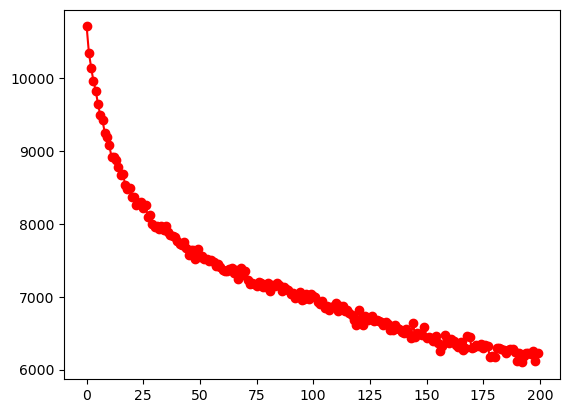

In [13]:
import matplotlib.pyplot as plt

x = [i for i in range(200)]
plt.plot(x,loss_li,color="red",marker="o")


In [14]:
with open(file = "neo_cmp_inner.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")